In [1]:
# all imports
import pathlib
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.lines as mlines

sns.set_style("darkgrid")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

benchmarks = ["DPSH", "DHN", "HashNet", "CEL", "DCH", "WGLHH", "HyP2"]
dbs = ["CIFAR_10", "NUS_WIDE", "MS_COCO", "ImageNet"]

In [11]:
# load raw data
results = []
for db in dbs:
    BENCH_EVAL_DIR = pathlib.Path(f"../eval/PenaltyStrategies/{db}/rotation_experiment")
    ROT_EVAL_DIR = pathlib.Path(f"../eval/H2Q/{db}/rotation_experiment")
    ITQ_EVAL_DIR = pathlib.Path(f"../eval/ITQ/{db}/rotation_experiment")
    ADSH_EVAL_DIR = pathlib.Path(f"../eval/ADSH/{db}/rotation_experiment")

    for d in tqdm(ADSH_EVAL_DIR.glob("*")):
        if ( d / f"val-prediction_mAP.json" ).exists():
            nbits = int(d.name.split("-nbits=")[-1].split("-")[0])
            seed = int(d.name.split("-seed=")[-1].split("-")[0])
            arch = d.name.split("-arch=")[-1].split("-")[0]
            results.append(
                {"db": db, "loss": "ADSH", "nbits": nbits,
                 "r_loss": '-', "seed": seed, "arch": arch, "penalty": '-',
                 "L2_penalty": '-', "HSWD_penalty": '-', "no_cube": '-'
                }
            )
            for fold in ["val", "query"]:
                exp_results = json.load(open( d / f"{fold}-prediction_mAP.json", "r" ))
                for metric in ["mAP_at_k=1000", "mAP_at_k=5000"]:
                    results[-1][f"{fold}_{metric}"] = exp_results[metric]*100

    for EVAL_DIR in [BENCH_EVAL_DIR, ROT_EVAL_DIR, ITQ_EVAL_DIR]:
        for d in tqdm(EVAL_DIR.glob("*")):
            loss = d.name.split("-loss=")[-1].split("-")[0]
            penalty = d.name.split("-penalty=")[-1].split("-")[0]
            pass_HyP2 = True
            if loss == "HyP2":
                pass_HyP2 = (penalty == "1.25" and db != "NUS_WIDE") or (penalty == "0.75" and db == "NUS_WIDE")
            if ( d / f"val-prediction_mAP.json" ).exists() and loss in benchmarks and pass_HyP2:
                nbits = int(d.name.split("-nbits=")[-1].split("-")[0])
                seed = int(d.name.split("-seed=")[-1].split("-")[0])
                arch = d.name.split("-arch=")[-1].split("-")[0]
                L2_penalty = "L2_penalty" in d.name
                HSWD_penalty = "HSWD_penalty" in d.name
                L2_penalty = L2_penalty and not HSWD_penalty
                no_cube = "no_cube" in d.name

                r_loss = "-"
                if "r_loss" in d.name:
                    r_loss = d.name.split("-r_loss=")[-1].split("-")[0]
                if EVAL_DIR == ITQ_EVAL_DIR:
                    r_loss = "ITQ"
                results.append(
                    {"db": db, "loss": loss, "nbits": nbits,
                     "r_loss": r_loss, "seed": seed, "arch": arch, "penalty": penalty,
                     "L2_penalty": L2_penalty, "HSWD_penalty": HSWD_penalty, "no_cube": no_cube
                    }
                )

                for fold in ["val", "query"]:
                    exp_results = json.load(open( d / f"{fold}-prediction_mAP.json", "r" ))
                    for metric in ["mAP_at_k=1000", "mAP_at_k=5000"]:
                        results[-1][f"{fold}_{metric}"] = exp_results[metric]*100

raw_results = pd.DataFrame(results)

32it [00:00, 196.68it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
320it [00:00, 558.06it/s]
32it [00:00, 717.79it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
320it [00:00, 444.06it/s]
32it [00:00, 428.79it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
320it [00:00, 1527.00it/s]
32it [00:00, 2047.63it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
320it [00:00, 1227.34it/s]


In [3]:
# define mAP at k using k=1000 to imagenet and k=5000 to other databases
raw_results["val_mAP"] = raw_results["val_mAP_at_k=1000"]*(raw_results.db == "ImageNet") + raw_results["val_mAP_at_k=5000"]*(raw_results.db != "ImageNet")
raw_results["query_mAP"] = raw_results["query_mAP_at_k=1000"]*(raw_results.db == "ImageNet") + raw_results["query_mAP_at_k=5000"]*(raw_results.db != "ImageNet")
del raw_results["val_mAP_at_k=1000"]
del raw_results["val_mAP_at_k=5000"]
del raw_results["query_mAP_at_k=1000"]
del raw_results["query_mAP_at_k=5000"]

#average over seeds with all other parameters fixed
fixed_cols = ["db","loss","nbits","r_loss","arch","penalty","L2_penalty","HSWD_penalty","no_cube"]
raw_results = raw_results.groupby(fixed_cols).agg({'val_mAP':['mean','std'], 'query_mAP':['mean','std']}).reset_index()
raw_results.columns = fixed_cols + ["val_mAP", "val_mAP_std", "query_mAP", "query_mAP_std"]

In [4]:
# get the right experimental configuration from the parameters
def get_configuration(row):
    if row["loss"] == "ADSH":
        return "ADSH"
    elif row["loss"] == "HashNet":
        if row["r_loss"] == "-":
            return "continuation"
        else:
            return "-"
    elif row["HSWD_penalty"]:
        return "HSWD"
    elif row["r_loss"] == "ITQ":
        return "l0+ITQ"
    elif row["r_loss"] in ["L2", "L1", "bit_var_loss", "min_entry"]:
        return "l0+H2Q+"+row["r_loss"]
    else:
        has_penalty = row["L2_penalty"] or ( row["loss"] not in ["HyP2", "CEL"] and row["penalty"] != "0.0" )
        if has_penalty:
            return "l>0"
        else:
            return "l0"
raw_results["strategy"] = raw_results.apply(lambda row: get_configuration(row), axis=1)

# delete the parameters that are now incorporated in the configuration
del raw_results["no_cube"]
del raw_results["r_loss"]
del raw_results["L2_penalty"]
del raw_results["HSWD_penalty"]

In [5]:
# get best penalizations on the l>0 strategy
lg0 = raw_results[raw_results.strategy == "l>0"]
lg0 = lg0.loc[lg0.groupby(["db", "loss", "nbits", "arch", "strategy"])['val_mAP'].idxmax()][["db", "loss", "nbits", "arch", "query_mAP", "query_mAP_std", "strategy"]]

# join with the rest of the data
non_lg0 = raw_results[raw_results.strategy != "l>0"]
del non_lg0["penalty"]
del non_lg0["val_mAP"]
del non_lg0["val_mAP_std"]

# use DHN to fill DPSH on the non_l>0 case
# since they have the same similarity loss
non_lg0 = non_lg0[ non_lg0.loss != "DPSH" ]
non_lg0_DPSH = non_lg0[ non_lg0.loss == "DHN" ].copy()
non_lg0_DPSH["loss"] = "DPSH"

results = pd.concat([lg0, non_lg0_DPSH, non_lg0])
results

,db,loss,nbits,arch,query_mAP,query_mAP_std,strategy
10,CIFAR_10,CEL,16,CNNF_alexnet,80.210887,0.331630,l>0
13,CIFAR_10,CEL,16,CNNF_vgg16,84.832376,0.672033,l>0
26,CIFAR_10,CEL,32,CNNF_alexnet,79.096092,1.029403,l>0
29,CIFAR_10,CEL,32,CNNF_vgg16,85.298244,0.242060,l>0
42,CIFAR_10,CEL,48,CNNF_alexnet,77.750547,0.355127,l>0
...,...,...,...,...,...,...,...
1915,NUS_WIDE,WGLHH,64,CNNF_vgg16,83.441407,0.188754,l0+H2Q+L2
1916,NUS_WIDE,WGLHH,64,CNNF_alexnet,81.364908,0.264196,l0+H2Q+bit_var_loss
1917,NUS_WIDE,WGLHH,64,CNNF_vgg16,83.417870,0.288376,l0+H2Q+bit_var_loss
1918,NUS_WIDE,WGLHH,64,CNNF_alexnet,81.323467,0.288873,l0+H2Q+min_entry


In [6]:
# compare strategies
def stack_strategies(df, sts):
    dfs = []
    for st in sts:
        df_st = df[ df.strategy == st ].copy()
        df_st[st] = df_st["query_mAP"]
        del df_st["query_mAP"]
        del df_st["query_mAP_std"] # need to fix
        del df_st["strategy"]
        dfs.append(df_st)
    df_final = dfs[0]
    for df_st in dfs[1:]:
        df_final = pd.merge(df_final, df_st, on=["db", "nbits", "loss", "arch"])

    for st in sts:
        if st != "l0":
            df_final[f"delta_{st}"] = df_final[st] - df_final["l0"]

    df_final["winner"] = df_final.apply(lambda row: sts[np.argmax([row[st] for st in sts])], axis = 1)
    return df_final

strategy_comparisons = stack_strategies(results, ["l0", "HSWD", "l0+H2Q+L2", "l0+H2Q+L1", "l0+H2Q+min_entry", "l0+H2Q+bit_var_loss", "l0+ITQ", "l>0"])

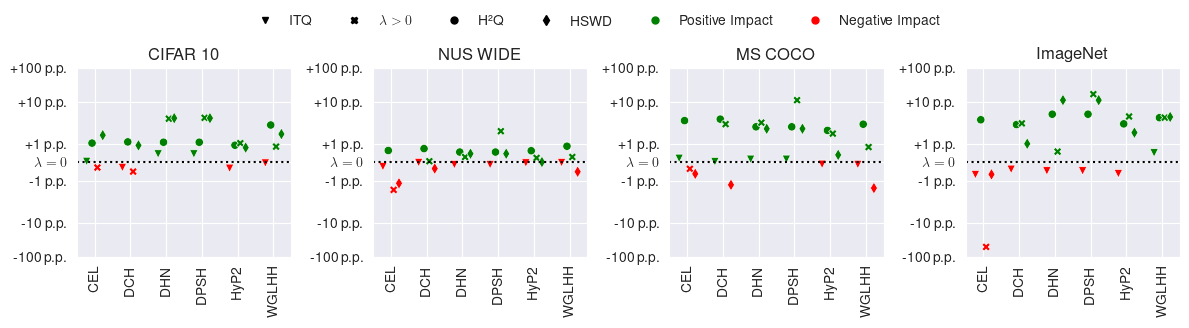

In [17]:
# plot strategies
strategies = ["delta_l0+ITQ", "delta_l0+H2Q+L2", "delta_l>0", "delta_HSWD"]
sc_deltas = strategy_comparisons.melt(
    id_vars=["db", "loss", "arch", "nbits"], value_vars=strategies,
    var_name="strategy", value_name="delta"
)
sc_deltas["improved"] = sc_deltas.delta > 0
losses = ["CEL", "DCH", "DHN", "DPSH", "HyP2", "WGLHH"]
# put jitter
sc_deltas["x"] = sc_deltas.apply(
    lambda row: losses.index(row["loss"]) + .15*(strategies.index(row["strategy"])-1.5),
    axis=1
)

nbits = 16
arch = "CNNF_vgg16"
plt.rcParams["figure.figsize"] = (12,3)
for i, db in enumerate(dbs):
    plt.subplot(1,4,i+1)
    sns.scatterplot(
        sc_deltas[ (sc_deltas.db == db) & (sc_deltas.nbits == nbits) & (sc_deltas.arch == arch) ],
        x="x", y="delta", style="strategy", hue="improved", palette={True: "green", False: "red"}, legend=None,
        markers={"delta_l0+ITQ": 'v', "delta_l>0": 'X', "delta_l0+H2Q+L2": 'o', "delta_HSWD": 'd'}
    )
    plt.plot([-.5, 5.5], [0,0], c="black", ls=":")
    plt.xlim([-.5, 5.5])
    plt.yscale("symlog")
    plt.yticks([-100, -10, -1, 0, 1, 10, 100], ["-100 p.p.", "-10 p.p.", "-1 p.p.", r"$\lambda=0$", "+1 p.p.", "+10 p.p.", "+100 p.p."])
    plt.xticks([0,1,2,3,4,5], losses, rotation=90)
    plt.xlabel("")
    plt.ylabel("")
    plt.title(db.replace("_", " "))

handles = [
    mlines.Line2D([], [], color='black', marker='v', linestyle='None', markersize=5),
    mlines.Line2D([], [], color='black', marker='X', linestyle='None', markersize=5),
    mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=5),
    mlines.Line2D([], [], color='black', marker='d', linestyle='None', markersize=5),
    mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=5),
    mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=5),
]
plt.figlegend(handles, ["ITQ",r"$\lambda > 0$", "H²Q", "HSWD", "Positive Impact", "Negative Impact"], loc = 'upper center', ncol=6, frameon=False, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout()
plt.savefig(f"other_quantizations_{nbits}_{arch}.pdf", bbox_inches='tight')

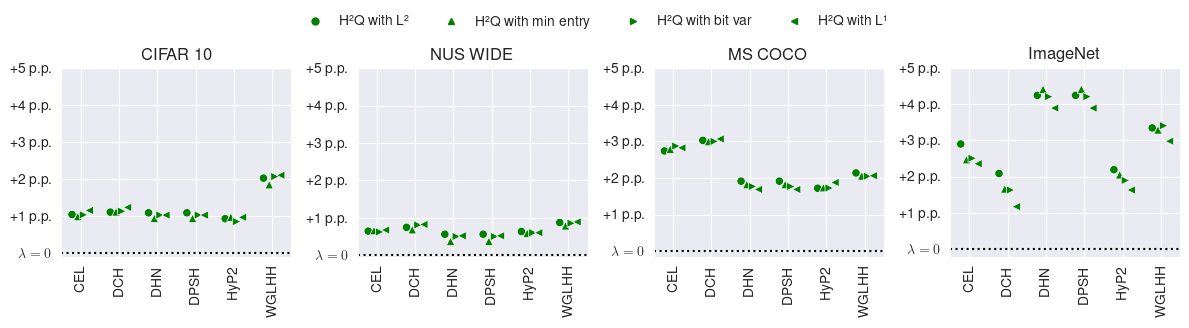

In [16]:
# plot strategies
strategies = ["delta_l0+H2Q+L2", "delta_l0+H2Q+L1", "delta_l0+H2Q+min_entry", "delta_l0+H2Q+bit_var_loss"]
sc_deltas = strategy_comparisons.melt(
    id_vars=["db", "loss", "arch", "nbits"], value_vars=strategies,
    var_name="strategy", value_name="delta"
)
sc_deltas["improved"] = sc_deltas.delta > 0
losses = ["CEL", "DCH", "DHN", "DPSH", "HyP2", "WGLHH"]
# put jitter
sc_deltas["x"] = sc_deltas.apply(
    lambda row: losses.index(row["loss"]) + .15*(strategies.index(row["strategy"])-1.5),
    axis=1
)

nbits = 16
arch = "CNNF_vgg16"
plt.rcParams["figure.figsize"] = (12,3)
for i, db in enumerate(dbs):
    plt.subplot(1,4,i+1)
    sns.scatterplot(
        sc_deltas[ (sc_deltas.db == db) & (sc_deltas.nbits == nbits) & (sc_deltas.arch == arch) ],
        x="x", y="delta", style="strategy", hue="improved", palette={True: "green", False: "red"}, legend=None,
        markers={"delta_l0+H2Q+L1": '^', "delta_l0+H2Q+min_entry": '>', "delta_l0+H2Q+bit_var_loss": "<", "delta_l0+H2Q+L2": 'o'}
    )
    plt.plot([-.5, 5.5], [0,0], c="black", ls=":")
    plt.xlim([-.5, 5.5])
    plt.yticks([0, 1, 2, 3, 4, 5], [r"$\lambda=0$", "+1 p.p.", "+2 p.p.", "+3 p.p.", "+4 p.p.", "+5 p.p."])
    plt.xticks([0,1,2,3,4,5], losses, rotation=90)
    plt.xlabel("")
    plt.ylabel("")
    plt.title(db.replace("_", " "))

handles = [
    mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=5),
    mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=5),
    mlines.Line2D([], [], color='green', marker='>', linestyle='None', markersize=5),
    mlines.Line2D([], [], color='green', marker='<', linestyle='None', markersize=5),
]
plt.figlegend(handles, ["H²Q with L²", "H²Q with min entry", "H²Q with bit var", "H²Q with L¹"], loc = 'upper center', ncol=6, frameon=False, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout()
plt.savefig(f"ablation_losses_{nbits}_{arch}.pdf", bbox_inches='tight')

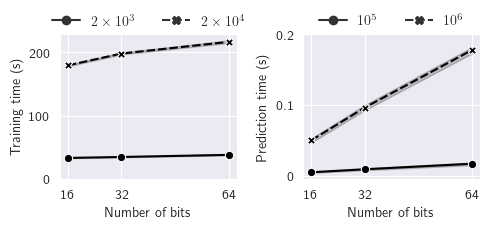

In [29]:
# plot times
fig, axs = plt.subplots(1, 2, figsize=(5,2.5))
plt.subplots_adjust(wspace=0, hspace=0)

sns.set_style("darkgrid")

time = pd.read_csv("../experiments/times.csv", sep=",", index_col=0)
time["train_n"] = (.02 * time["n"]).astype(int)

ttimes = sns.lineplot(time, x="nbits", y="train_times", style="train_n", markers=True, color="black", ax=axs[0])
ttimes.set_xticks([16, 32, 64])
ttimes.set_xticklabels([16, 32, 64])
ttimes.set_yticks([0, 100, 200])
ttimes.set_yticklabels([0, 100, 200])
axs[0].set_ylabel("Training time (s)")
axs[0].set_xlabel("Number of bits")

handles, _ = ttimes.get_legend_handles_labels()
ttimes.legend(loc = "upper center", bbox_to_anchor=(0.5, 1.22), ncol=2,
    frameon=False, labels=[r"$2\times 10^3$", r"$2\times 10^4$"], handles=handles)

ptimes = sns.lineplot(time, x="nbits", y="predict_times", style="n", markers=True, color="black", ax=axs[1])
ptimes.set_xticks([16, 32, 64])
ptimes.set_xticklabels([16, 32, 64])
ptimes.set_yticks([0, 0.1, 0.2])
ptimes.set_yticklabels([0, 0.1, 0.2])
axs[1].set_ylabel("Prediction time (s)")
axs[1].set_xlabel("Number of bits")
handles, _ = ptimes.get_legend_handles_labels()
ptimes.legend(loc = "upper center", bbox_to_anchor=(0.5, 1.22), ncol=2,
    frameon=False, labels=[r"$10^5$", r"$10^6$"], handles=handles)

plt.tight_layout()
fig.savefig(f"comp_time.pdf", bbox_inches='tight')

In [7]:
# table utils
def get_lines(
        df,
        loss,
        arch,
        strategies,
        nbs=[16, 32, 48, 64],
        dbs=["CIFAR_10", "NUS_WIDE", "MS_COCO", "ImageNet"],
        with_std = False
):
    df_filtered = df[ (df.loss == loss) & (df.strategy.isin(strategies)) & (df.arch == arch) & (df.nbits.isin(nbs)) & (df.db.isin(dbs)) ]
    lines = []
    for strategy in strategies:
        line = []
        for db in dbs:
            for nb in nbs:
                v = df_filtered.query_mAP[(df_filtered.db == db)&(df_filtered.strategy == strategy)&(df_filtered.nbits == nb)].values[0]
                if with_std:
                    s = df_filtered.query_mAP_std[(df_filtered.db == db)&(df_filtered.strategy == strategy)&(df_filtered.nbits == nb)].values[0]
                    line.append((v,s))
                else:
                    line.append(v)
        lines.append(line)

    return lines

def print_table_head(no_skip=False):
    print("\\begin{table*}[]\\centering")
    if no_skip:
        print("\\begin{tabular}{l@{\\hskip .01in}|c@{\\hskip .01in}c@{\\hskip .01in}c@{\\hskip .01in}c|c@{\\hskip .01in}c@{\\hskip .01in}c@{\\hskip .01in}c|c@{\\hskip .01in}c@{\\hskip .01in}c@{\\hskip .01in}c|c@{\\hskip .01in}c@{\\hskip .01in}c@{\\hskip .01in}c}")
    else:
        print("\\begin{tabular}{l|c@{\\hskip .08in}c@{\\hskip .08in}c@{\\hskip .08in}c|c@{\\hskip .08in}c@{\\hskip .08in}c@{\\hskip .08in}c|c@{\\hskip .08in}c@{\\hskip .08in}c@{\\hskip .08in}c|c@{\\hskip .08in}c@{\\hskip .08in}c@{\\hskip .08in}c}")
    print("& \\multicolumn{4}{c|}{CIFAR 10} & \\multicolumn{4}{c|}{NUS WIDE} & \\multicolumn{4}{c|}{MS COCO} & \\multicolumn{4}{c}{ImageNet} \\\\ \\hline")
    print("n bits & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64\\\\ \\hline")

def print_table_footer(caption, label):
    print("\\end{tabular}")
    print("\\caption{"+caption+".}")
    print("\\label{tab:"+label+"}")
    print("\\end{table*}")

def format_lines(lines, loss_label, strategy_labels, underline=False, color_bad=False, put_separation=True):
    has_std = False
    if isinstance(lines[0][0], tuple):
        has_std = True
        lines_only_avg = [ [ v for (v,_) in line ] for line in lines]
    else:
        lines_only_avg = lines

    best_lines = np.argmax(lines_only_avg, axis=0)
    non_improv_lines = np.array(lines_only_avg) - np.array(lines_only_avg[0])[None, :] < 0

    for i, (line, strategy_label) in enumerate(zip(lines, strategy_labels)):
        if has_std:
            str_line = "{" + f"\\footnotesize {loss_label}{strategy_label}" + "}"
        else:
            str_line = f"{loss_label}{strategy_label}"
        for j, v in enumerate(line):
            if has_std:
                str_value = "{\\footnotesize" + f"{v[0]:.1f}$^" + "{" + f"{v[1]:.1f}" + "}$}"
            else:
                str_value = f"{v:.1f}" 
            if underline and i == best_lines[j]:
                str_value = "\\textbf{" + str_value + "}"
            if color_bad and non_improv_lines[i][j]:
                str_value = "{\\color{red}" + str_value + "}"
            str_line += " & "+str_value
        if i == len(strategy_labels) - 1 and put_separation:
            print(str_line + "\\\\[.5em]")
        else:
            print(str_line + "\\\\")


In [9]:
# make table that comparing our method with the sota
for arch in ["CNNF_alexnet", "CNNF_vgg16"]:
    print_table_head()
    format_lines(get_lines(results, "ADSH", arch=arch, strategies=["ADSH"]), "ADSH", strategy_labels=[""], put_separation=False)
    format_lines(get_lines(results, "CEL", arch=arch, strategies=["l0"]), "CEL", strategy_labels=[""], put_separation=False)
    format_lines(get_lines(results, "DCH", arch=arch, strategies=["l>0"]), "DCH", strategy_labels=[""], put_separation=False)
    format_lines(get_lines(results, "DHN", arch=arch, strategies=["l>0"]), "DHN", strategy_labels=[""], put_separation=False)
    format_lines(get_lines(results, "DPSH", arch=arch, strategies=["l>0"]), "DPSH", strategy_labels=[""], put_separation=False)
    format_lines(get_lines(results, "HashNet", arch=arch, strategies=["continuation"]), "HashNet", strategy_labels=[""], put_separation=False)
    format_lines(get_lines(results, "WGLHH", arch=arch, strategies=["l>0"]), "WGLHH", strategy_labels=[""], put_separation=True)
    format_lines(get_lines(results, "HyP2", arch=arch, strategies=["l0", "l0+ITQ", "HSWD", "l0+H2Q+L2"]), "HyP²", strategy_labels=["", " + ITQ", " + HSWD", " + H²Q"], put_separation=False)
    print_table_footer("\\texttt{mAP@k} with "+arch[5:], f"sota_{arch}")

\begin{table*}[]\centering
\begin{tabular}{l|c@{\hskip .08in}c@{\hskip .08in}c@{\hskip .08in}c|c@{\hskip .08in}c@{\hskip .08in}c@{\hskip .08in}c|c@{\hskip .08in}c@{\hskip .08in}c@{\hskip .08in}c|c@{\hskip .08in}c@{\hskip .08in}c@{\hskip .08in}c}
& \multicolumn{4}{c|}{CIFAR 10} & \multicolumn{4}{c|}{NUS WIDE} & \multicolumn{4}{c|}{MS COCO} & \multicolumn{4}{c}{ImageNet} \\ \hline
n bits & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64\\ \hline
ADSH & 56.7 & 71.8 & 77.3 & 79.7 & 74.8 & 78.4 & 79.8 & 80.3 & 57.9 & 61.1 & 63.7 & 65.0 & 5.2 & 8.3 & 13.4 & 23.2\\
CEL & 79.8 & 81.0 & 81.7 & 81.3 & 79.4 & 80.3 & 80.7 & 80.7 & 64.4 & 66.3 & 67.5 & 68.4 & 51.8 & 52.5 & 53.7 & 45.6\\
DCH & 80.2 & 80.1 & 80.0 & 79.8 & 78.4 & 79.1 & 79.1 & 79.8 & 63.8 & 66.2 & 67.1 & 66.7 & 58.2 & 58.8 & 58.9 & 60.4\\
DHN & 81.2 & 81.1 & 81.1 & 81.3 & 80.6 & 81.3 & 81.6 & 81.7 & 66.8 & 67.3 & 69.2 & 69.4 & 25.1 & 32.4 & 35.7 & 38.2\\
DPSH & 81.2 & 81.2 & 81.5 & 81.1 & 81.0 & 81.9 & 82

In [14]:
# make table showing how we improve the metrics
for arch in ["CNNF_alexnet", "CNNF_vgg16"]:
    print_table_head()
    format_lines(get_lines(results, "CEL", arch=arch, strategies=["l0", "l0+H2Q+L2"]), "CEL", strategy_labels=[" ($\\lambda=0$)", " + H²Q"], underline=True)
    format_lines(get_lines(results, "DCH", arch=arch, strategies=["l0", "l0+H2Q+L2"]), "DCH", strategy_labels=[" ($\\lambda=0$)", " + H²Q"], underline=True)
    format_lines(get_lines(results, "DHN", arch=arch, strategies=["l0", "l0+H2Q+L2"]), "DHN", strategy_labels=[" ($\\lambda=0$)", " + H²Q"], underline=True)
    format_lines(get_lines(results, "DPSH", arch=arch, strategies=["l0", "l0+H2Q+L2"]), "DPSH", strategy_labels=[" ($\\lambda=0$)", " + H²Q"], underline=True)
    format_lines(get_lines(results, "WGLHH", arch=arch, strategies=["l0", "l0+H2Q+L2"]), "WGLHH", strategy_labels=[" ($\\lambda=0$)", " + H²Q"], underline=True)
    format_lines(get_lines(results, "HyP2", arch=arch, strategies=["l0", "l0+H2Q+L2"]), "HyP²", strategy_labels=[" ($\\lambda=0$)", " + H²Q"], underline=True)
    print_table_footer("\\texttt{mAP@k} with "+arch[5:], f"improve_{arch}")

\begin{table*}[]\centering
\begin{tabular}{l|c@{\hskip .08in}c@{\hskip .08in}c@{\hskip .08in}c|c@{\hskip .08in}c@{\hskip .08in}c@{\hskip .08in}c|c@{\hskip .08in}c@{\hskip .08in}c@{\hskip .08in}c|c@{\hskip .08in}c@{\hskip .08in}c@{\hskip .08in}c}
& \multicolumn{4}{c|}{CIFAR 10} & \multicolumn{4}{c|}{NUS WIDE} & \multicolumn{4}{c|}{MS COCO} & \multicolumn{4}{c}{ImageNet} \\ \hline
n bits & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64\\ \hline
CEL ($\lambda=0$) & 79.8 & 81.0 & 81.7 & 81.3 & 79.4 & 80.3 & 80.7 & 80.7 & 64.4 & 66.3 & 67.5 & 68.4 & 51.8 & 52.5 & 53.7 & 45.6\\
CEL + H²Q & \textbf{82.2} & \textbf{82.4} & \textbf{82.7} & \textbf{82.4} & \textbf{80.6} & \textbf{81.9} & \textbf{82.2} & \textbf{82.3} & \textbf{66.4} & \textbf{68.5} & \textbf{69.6} & \textbf{70.2} & \textbf{54.6} & \textbf{55.0} & \textbf{56.1} & \textbf{48.4}\\[.5em]
DCH ($\lambda=0$) & 78.3 & 77.5 & 77.3 & 76.3 & 78.8 & 78.9 & 78.5 & 78.6 & 62.8 & 64.1 & 64.2 & 64.3 & 50.9 & 49.6 

In [60]:
# stats pro paulo
sts = ["l0", "l0+ITQ", "l>0", "HSWD", "l0+H2Q+L2", "l0+H2Q+L1", "l0+H2Q+min_entry", "l0+H2Q+bit_var_loss"]
sts = ["l0", "l0+ITQ", "l>0", "HSWD", "l0+H2Q+L2"]

for arch in ["CNNF_alexnet", "CNNF_vgg16"]:
    improves = []
    for bench in ["CEL", "DCH", "DHN", "DPSH", "WGLHH", "HyP2"]:
        lines = np.array(get_lines(results, bench, arch=arch, strategies=sts))
        # improve = (lines[1:,:] - lines[0,None])/lines[0, None]*100
        improve = lines[1:,:] - lines[0,None]
        improves.append(improve)

    improves_ = np.hstack(improves)
    print("-------------------")
    print(arch)
    print(f"strategy | max | min | mean | median | wins")
    for nbits, improves in zip(["All", 16, 32, 48, 64], [improves_, improves_[:,0::4], improves_[:,1::4], improves_[:,2::4], improves_[:,3::4]]):
        bests = np.argmax(improves, axis=0)
        for i, st, M, m, av, med in zip(range(len(sts)-1),sts[1:],np.max(improves, axis=1),np.min(improves, axis=1),np.mean(improves, axis=1), np.median(improves, axis=1) ):
            print(f"{nbits} | {st} | {M:.2f}p.p. | {m:.2f}p.p. | {av:.2f}p.p. | {med:.2f}p.p. | {(bests == i).sum()}")


-------------------
CNNF_alexnet
strategy | max | min | mean | median | wins
All | l0+ITQ | 0.94p.p. | -0.60p.p. | 0.02p.p. | 0.02p.p. | 0
All | l>0 | 13.92p.p. | -32.67p.p. | 1.22p.p. | 1.60p.p. | 39
All | HSWD | 8.92p.p. | -8.04p.p. | 1.56p.p. | 1.00p.p. | 14
All | l0+H2Q+L2 | 6.28p.p. | 0.32p.p. | 2.09p.p. | 1.75p.p. | 43
16 | l0+ITQ | 0.26p.p. | -0.60p.p. | -0.10p.p. | -0.04p.p. | 0
16 | l>0 | 12.31p.p. | -32.67p.p. | 1.03p.p. | 1.44p.p. | 9
16 | HSWD | 8.92p.p. | -8.04p.p. | 1.73p.p. | 0.99p.p. | 3
16 | l0+H2Q+L2 | 4.59p.p. | 0.63p.p. | 2.04p.p. | 1.75p.p. | 12
32 | l0+ITQ | 0.94p.p. | -0.42p.p. | 0.01p.p. | -0.02p.p. | 0
32 | l>0 | 10.58p.p. | -30.34p.p. | 1.26p.p. | 1.53p.p. | 7
32 | HSWD | 8.12p.p. | -4.48p.p. | 1.84p.p. | 1.65p.p. | 6
32 | l0+H2Q+L2 | 6.26p.p. | 0.65p.p. | 2.18p.p. | 1.82p.p. | 11
48 | l0+ITQ | 0.45p.p. | -0.33p.p. | 0.04p.p. | 0.06p.p. | 0
48 | l>0 | 11.80p.p. | -30.35p.p. | 1.27p.p. | 2.02p.p. | 11
48 | HSWD | 8.61p.p. | -4.20p.p. | 1.38p.p. | 0.93p.p. | 3
4

In [15]:
# make big table for the SM
sts = ["l0", "l0+ITQ", "l>0", "HSWD", "l0+H2Q+L2", "l0+H2Q+L1", "l0+H2Q+min_entry", "l0+H2Q+bit_var_loss"]
st_labels = ["($\\lambda=0$)", "+ITQ", "+$\\lambda$", "+HSWD", "+H²Q($L_2$)",  "+H²Q($L_1$)", "+H²Q(min)", "+H²Q(bit)" ]
for arch in ["CNNF_alexnet", "CNNF_vgg16"]:
    print_table_head(no_skip=True)
    format_lines(get_lines(results, "CEL", arch=arch, strategies=sts, with_std=True), "CEL", strategy_labels=st_labels, underline=True, color_bad=True)
    format_lines(get_lines(results, "DCH", arch=arch, strategies=sts, with_std=True), "DCH", strategy_labels=st_labels, underline=True, color_bad=True)
    format_lines(get_lines(results, "DHN", arch=arch, strategies=sts, with_std=True), "DHN", strategy_labels=st_labels, underline=True, color_bad=True)
    format_lines(get_lines(results, "DPSH", arch=arch, strategies=sts, with_std=True), "DPSH", strategy_labels=st_labels, underline=True, color_bad=True)
    format_lines(get_lines(results, "WGLHH", arch=arch, strategies=sts, with_std=True), "WGL.", strategy_labels=st_labels, underline=True, color_bad=True)
    format_lines(get_lines(results, "HyP2", arch=arch, strategies=sts, with_std=True), "HyP²", strategy_labels=st_labels, underline=True, color_bad=True)
    print_table_footer("\\texttt{mAP@k} with "+arch[5:], f"improve_{arch}")

\begin{table*}[]\centering
\begin{tabular}{l@{\hskip .01in}|c@{\hskip .01in}c@{\hskip .01in}c@{\hskip .01in}c|c@{\hskip .01in}c@{\hskip .01in}c@{\hskip .01in}c|c@{\hskip .01in}c@{\hskip .01in}c@{\hskip .01in}c|c@{\hskip .01in}c@{\hskip .01in}c@{\hskip .01in}c}
& \multicolumn{4}{c|}{CIFAR 10} & \multicolumn{4}{c|}{NUS WIDE} & \multicolumn{4}{c|}{MS COCO} & \multicolumn{4}{c}{ImageNet} \\ \hline
n bits & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64 & 16 & 32 & 48 & 64\\ \hline
{\footnotesize CEL($\lambda=0$)} & {\footnotesize79.8$^{0.6}$} & {\footnotesize81.0$^{0.4}$} & {\footnotesize81.7$^{0.3}$} & {\footnotesize81.3$^{0.2}$} & {\footnotesize79.4$^{0.2}$} & {\footnotesize80.3$^{0.2}$} & {\footnotesize80.7$^{0.2}$} & {\footnotesize80.7$^{0.3}$} & {\footnotesize64.4$^{0.5}$} & {\footnotesize66.3$^{0.6}$} & {\footnotesize67.5$^{0.3}$} & {\footnotesize68.4$^{0.4}$} & {\footnotesize51.8$^{1.1}$} & {\footnotesize52.5$^{0.3}$} & {\footnotesize53.7$^{1.1}$} & {\footnotesize45.6$^{0